In [4]:
import numpy as np
from discretize import TensorMesh, CylindricalMesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from simpegaem import SimulationAEM
from SimPEG import utils
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from pymatsolver import PardisoSolver
# from pymatsolver import Solver
%matplotlib inline

In [5]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 20.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
    mesh = CylindricalMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = TensorMesh([hx, hy, hz], 'CCC')
active = mesh.cell_centers[:,2] < 0.
sigma_background = 1./20
sigma_layer = 1./20
sigma = np.ones(mesh.n_cells)*1e-8
sigma[active] = sigma_background
ind_layer = np.logical_and(mesh.cell_centers[:,2]<-100., mesh.cell_centers[:,2]>-200.)
sigma[ind_layer] = sigma_layer
rho = 1./sigma

eps = 1e-8
start_time = -0.02
peak_time = -0.01
off_time = 0.
triangle_waveform = tdem.sources.TriangularWaveform(
        start_time=start_time, peak_time=peak_time, off_time=off_time
)
triangle_waveform.has_initial_fields = True
receiver_orientation = "z"                    # "x", "y" or "z"
z_src = 30
x_rx = 10.
z_offset = 0.
receiver_location = np.array([x_rx, 0., z_src+z_offset])
source_location = np.array([0., 0., z_src])
times = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)
rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    receiver_location, times, orientation=receiver_orientation
)


receiver_list = [rx]
src_1 = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=triangle_waveform, orientation='z'
)

src_2 = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=triangle_waveform, orientation='z'
)


# Survey
source_list = [src_1, src_2]
survey = tdem.Survey(source_list)

    
def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)
# dts = np.diff(np.logspace(-7, -1, 60))
# time_steps = []
# for dt in dts:
#     time_steps.append((dt, 1))

time_steps = generate_time_steps(n_constant_steps=15, increase_rate=2, start_time_step=1e-6, n_per_step=5)

simulation_3d = SimulationAEM(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps
)    

t_min:1.0e-06, t_max:1.6e-01


In [6]:
for i_src, src in enumerate(survey.source_list):
    i_start = survey.vnD[:i_src].sum()
    i_end = i_start + survey.vnD[i_src]
    print (i_start, i_end)

0 31
31 62


In [7]:
test = np.random.randn(20)

In [8]:
test

array([-0.03592032, -1.2996036 ,  0.88910391, -0.58599449,  0.46299895,
       -0.7682623 , -1.09518904, -1.4676868 ,  1.94498212, -0.32104045,
       -0.41461398, -0.03542982,  3.27152909, -0.26738117,  0.73425499,
       -0.29752352, -0.21651329,  1.86548256,  0.71822646,  0.22696286])

In [9]:
test[0:0+3]

array([-0.03592032, -1.2996036 ,  0.88910391])

In [10]:
test[3:6]

array([-0.58599449,  0.46299895, -0.7682623 ])

In [11]:
f = simulation_3d.fields(sigma)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [12]:
data = simulation_3d.dpred(sigma, f=f)

In [13]:
data_no_store = simulation_3d.dpred_no_store(sigma)

In [14]:
from SimPEG.utils import plot_1d_layer_model

# Layer thicknesses
thicknesses = np.array([100.0, 100.0])
n_layer = len(thicknesses) + 1

# physical property model (conductivity model)
model = sigma_background * np.ones(n_layer)
model[1] = sigma_layer

# Define a mapping from model parameters to conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict data for a given model
sigma_1d =  model
data_analytic = simulation.dpred(sigma_1d)

In [15]:
simulation_3d.survey.vnD

array([31, 31])

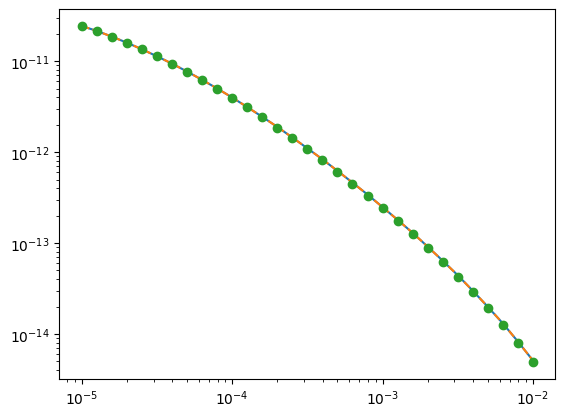

In [16]:
plt.loglog(rx.times, -data[:rx.times.size])
plt.loglog(rx.times, -data_no_store[:rx.times.size], '--')
plt.loglog(rx.times, -data_analytic[:rx.times.size], 'o')

In [17]:
%%time
f = simulation_3d.fields(sigma)

CPU times: user 2.14 s, sys: 954 ms, total: 3.1 s
Wall time: 333 ms


In [18]:
%%time
J_sigma = simulation_3d.getJ_sigma(sigma, f=f)

CPU times: user 6.71 s, sys: 1.84 s, total: 8.55 s
Wall time: 1.01 s


In [19]:
from SimPEG import maps
active_map = maps.InjectActiveCells(mesh, indActive=active, valInactive=np.log(1e-8))
exp_map = maps.ExpMap(mesh)
mapping = exp_map * active_map
m = np.ones(active.sum()) * np.log(1./20.)
sigma = mapping * m

In [20]:
def dpred(m):
    sigma = mapping * m    
    dpred = simulation_3d.dpred(sigma)
    return dpred

def dpred_dm(m, obs):
    sigma = mapping * m
    uncert = abs(obs) * 0.03
    return utils.sdiag(1./uncert) @ simulation_3d.getJ_sigma(sigma) * mapping.deriv(m)

def data_misfit(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    return np.linalg.norm(r)**2

def data_misfit_dm(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    J = dpred_dm(m, obs)
    return 2*J.T@r

In [21]:
# Order test
factors = [0.1, 0.01, 0.001, 0.0001]
m_true = np.ones(active.sum()) * np.log(1./20.)
m_0 = m_true * 2

obs = dpred(m_true)
dm0 = m_0*2

order_1 = np.zeros(len(factors))
order_2 = np.zeros(len(factors))

for ii, factor in enumerate(factors):
    dm = dm0 * factor
    order_1[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)
    )**2
    order_2[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)-data_misfit_dm(m_0, obs).dot(dm.T)
    )**2
#     print (">> {:.1e}, {:.1e}, {:.1e}".format(factor, order_1[ii], order_2[ii]))
    if ii > 0:
        ratio_1 = order_1[ii]/order_1[ii-1]
        ratio_2 = order_2[ii]/order_2[ii-1]
        
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.log10(ratio_1/ratio_2)))
    else:
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.nan))

>> 1.0e-01, 8.0e+06, 7.0e+06, nan
>> 1.0e-02, 2.6e+05, 1.5e+03, 2.2
>> 1.0e-03, 3.0e+03, 1.6e-01, 2.0
>> 1.0e-04, 3.0e+01, 1.6e-05, 2.0
